# Using sentiment data to predict future stock market performance

This notebook conducts a sentiment analysis of earnings call transcripts and examines how the tone in the earning calls influences short-term stock market reactions. Sentiment is measured using the Loughran and McDonald (2018) financial dictionary, while the dependent variable cumulative abnormal returns (CARs) captures the market’s response around the event window. To isolate the effect of sentiment, the analysis includes control variables such as stock return volatility, firm size, leverage. 



## Installation and Import

This section sets up the Python environment used for the analysis. All necessary libraries are installed and imported, including packages for data management, text processing, visualization, and econometric modeling. The `spaCy` language model *en_core_web_md* is also loaded for natural language processing of the earnings call transcripts.

In [12]:
!pip3 install --upgrade matplotlib pandas numpy datetime pandas_datareader statsmodels spacy openpyxl scikit-learn seaborn yfinance
!python3 -m spacy download en_core_web_sm


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.7 MB/s  0:00:03m0:00:0100:01

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [13]:
# Standard libraries
import os
import pickle
from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd

# Natural Language Processing
import spacy

# Statistics and econometrics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load model
nlp = spacy.load("en_core_web_md")
print("spaCy model loaded successfully")

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.max_columns", None)


spaCy model loaded successfully


For clarity, data preprocessing is divided into four parts:

1) Transcripts and lexicon processing
2) Data loading (precomputed sentiment scores)  
3) Dependent variable construction (cumulative abnormal returns)
4) Control variable creation (volatility, size, leverage)


## Transcripts and lexicon processing 

Below, two functions are defined to extract and clean transcript text for sentiment analysis. They convert the transcript to a string, tokenize, lemmatize, lowercase, and remove stopwords and punctuation. This ensures consistency for matching with the LM lexicon.


In [14]:
# Define function for text extraction
def extract_transcript_text(transcript):

    """
    Concatenate all speech segments from a transcript dictionary into a single string.

    Parameters:
        transcript (dict): A dictionary containing the transcript data, where each entry 
                       under 'transcript' includes a 'speech' field with text segments.

    Returns:
        str: All speech text combined into one string.
    """

    text_transcript = ''
    for speech in transcript['transcript']:
        speech_text = speech['speech'][0]
        text_transcript = text_transcript + ' ' + speech_text
    return text_transcript

# Define function for text processing 
def process_spacy_doc(text):

    """
    Process text using spaCy to lemmatize, lowercase, and remove stop words, punctuation, and spaces.

    To avoid performance issues, the text is truncated to 80,000 characters.

    Parameters:
        text (str): The input text to be processed.

    Returns:
        list: A list of cleaned and lemmatized words.
   """


    # Set a character limit to avoid processing excessively long texts 
    text = text[:80_000]
        
    words = [
        word.lemma_.lower()                # Lemmatize words and change to lowercase
        for word in nlp(text)              # Tokenize the text 
        if not (
            word.is_space                  # Remove spaces
            or word.is_stop                # Remove common stop words (e.g., "and", "the")
            or word.is_punct               # Remove punctuation
        )
    ]
   
    # Remove any empty strings from the list
    return [word for word in words if word]

Below, the Loughran-McDonald (LM) financial sentiment word lists are loaded. The LM lexicon is tailored for finance and classifies words as positive, negative, or uncertain. These lists are used to measure the tone of earnings call transcripts and analyze its impact on market reactions.

In [15]:
# Load the negative, positive and uncertainty lists in the Loughran-McDonald (LM) financial lexicon
try:
    LM_negative = pd.read_excel('LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Negative', header=None)
    LM_positive = pd.read_excel('LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Positive', header=None)
    LM_uncertainty = pd.read_excel('LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Uncertainty', header=None)
    
    # Clean and normalize the lexicon words so they match the processed transcript text
    LM_positive_processed = process_spacy_doc(' '.join(list(LM_positive[0])))
    LM_negative_processed = process_spacy_doc(' '.join(list(LM_negative[0])))
    LM_uncertainty_processed = process_spacy_doc(' '.join(list(LM_uncertainty[0])))
    
    # Convert word lists to sets for faster word lookup when scoring transcripts
    LM_positive = set(LM_positive_processed)
    LM_negative = set(LM_negative_processed)
    LM_uncertainty = set(LM_uncertainty_processed)

    print(f"LM Lexicon loaded and processed - Positive: {len(LM_positive)}, Negative: {len(LM_negative)}, Uncertainty: {len(LM_uncertainty)}")
except FileNotFoundError:
    print("ERROR: 'LoughranMcDonald_SentimentWordLists_2018.xlsx' not found.")

LM Lexicon loaded and processed - Positive: 298, Negative: 1816, Uncertainty: 238


Below, a third function is defined to measure sentiment in earnings call transcripts. It processes the text, counts positive, negative, and uncertainty words using the LM lexicon, and returns normalized sentiment ratios for each transcript.

In [16]:
# Function to score sentiment in transcripts
def score_transcript(transcript, LM_positive, LM_negative, LM_uncertainty):
    """
    Calculate sentiment scores for a single transcript using the Loughran–McDonald (LM) lexicon.

    Parameters:
        transcript (dict): Transcript data containing speech segments.
        LM_positive (set): Set of positive sentiment words.
        LM_negative (set): Set of negative sentiment words.
        LM_uncertainty (set): Set of uncertainty-related words.

    Returns:
        tuple: A tuple (positive_ratio, negative_ratio, uncertainty_ratio), 
        representing the proportion of each sentiment type relative to total words.
    """

    # Extract text and process 
    text = extract_transcript_text(transcript)
    words = process_spacy_doc(text)
    
    number_of_words = len(words)
    
    if number_of_words == 0:
        return (0.0, 0.0, 0.0)

    # Count occurrences 
    counts = Counter(words)
    keys = set(counts.keys())
    
    # Count how many times transcript words match each sentiment category using set intersection
    pos_count = sum([counts[k] for k in (keys & LM_positive)])
    neg_count = sum([counts[k] for k in (keys & LM_negative)])
    unc_count = sum([counts[k] for k in (keys & LM_uncertainty)])
    
    # Calculate ratios
    pos = round(pos_count / number_of_words, 4)
    neg = round(neg_count / number_of_words, 4)
    unc = round(unc_count / number_of_words, 4)
    
    return (pos, neg, unc)


This section uses a memory-efficient workflow to handle large volumes of transcript data for each of the 60 tickers:

**READ:** Load the pickled transcript data for one company.

**PROCESS:** Use `score_transcript` to calculate Positive, Negative, and Uncertainty sentiment ratios for each quarterly call.

**STORE:** Save the results (Ticker, Date, and sentiment scores) to the `all_results` list.

This approach ensures only the final sentiment scores are kept in memory, not the full text of all transcripts.


## Note
The cell below was originally used to process all transcripts and calculate sentiment scores. However, this step took a very long time to run. To save time and avoid repeating the lengthy computation, I commented out the code after running it once and saved the results to a CSV file. Now, I simply load the CSV file in later cells to continue the analysis efficiently. This approach ensures the notebook runs quickly and avoids unnecessary reprocessing.


In [17]:
# The code loads transcripts, scores sentiment, and saves results to a CSV file.

# tickers = ["TSM", "AMGN", "WFC", "AXP", "GM", "MSFT", "MRK", "ORCL", "TMUS", "UPS", "MET", "V", "DIS", "PG", "BKNG", "JPM", "MS", "TD", "GS", "UNH", "QCOM", "IBM", "AMD", "DUK", "MCD", "AMT", "AAPL", "BAC", "CHTR", "NVS", "MA", "AMZN", "LOW", "BMY", "C", "CMCSA", "PEP", "SAP", "F", "LMT", "TMO", "AZN", "NFLX", "CVS", "TXN", "SE", "FB", "GOOG", "CRM", "ADBE", "CVX", "ABT", "XOM", "ABBV", "EBAY", "RY", "TSLA", "SBUX", "UNP", "BA"]
# folder_path = "Pickles" 

# all_results = []   # List to store sentiment scores and metadata for each transcript

# print(f"Starting sentiment analysis on {len(tickers)} tickers...")

# for i, ticker in enumerate(tickers):
#     file_path = os.path.join(folder_path, f"{ticker}.p")
    
#     try:
#         # READ: Load all transcripts for one ticker
#         transcripts = pickle.load(open(file_path, "rb"))
#         print(f"[{i+1}/{len(tickers)}] Processing {ticker} ({len(transcripts)} calls)")

#         # PROCESS: Score each transcript
#         for transcript in transcripts:
#             pos_score, neg_score, unc_score = score_transcript(
#                 transcript, LM_positive, LM_negative, LM_uncertainty
#             )

#             # STORE: Save results
#             all_results.append({
#                 'Ticker': transcript['symbol'],
#                 'Date': pd.to_datetime(transcript['time']),
#                 'Year': transcript['year'],
#                 'Quarter': transcript['quarter'],
#                 'Positive_Ratio': pos_score,
#                 'Negative_Ratio': neg_score,
#                 'Uncertainty_Ratio': unc_score,
#                 'Net_Sentiment': pos_score - neg_score
#             })
            
#     except FileNotFoundError:
#         print(f"File not found for {ticker} at {file_path}. Skipping.")
#     except Exception as e:
#         print(f"An error occurred while processing {ticker}: {e}")

# print("\n--- Sentiment Analysis Execution Complete ---")

# # Convert final list to DataFrame
# final_df = pd.DataFrame(all_results)
# final_df = final_df.sort_values(by='Date').reset_index(drop=True)
# print(f"\nFinal DataFrame contains {len(final_df)} quarterly sentiment scores.")
# print("--- Final Data Snapshot ---")
# print(final_df.head())    

# final_df.to_csv("transcript_sentiment_scores.csv", index=False)



## Data Loading

Load precomputed sentiment scores (independent variables)


In [18]:
# Load the precomputed sentiment scores from CSV to avoid re-running the lengthy processing step
final_df = pd.read_csv("transcript_sentiment_scores.csv")

# Inspect the loaded DataFrame
final_df.head()

,Ticker,Date,Year,Quarter,Positive_Ratio,Negative_Ratio,Uncertainty_Ratio,Net_Sentiment
0,XOM,2005-10-31 00:40:28,2005,3,0.0281,0.0190,0.0118,0.0091
1,AZN,2005-11-09 21:51:12,2005,3,0.0205,0.0197,0.0158,0.0008
2,CMCSA,2005-11-16 15:11:37,2005,3,0.0316,0.0097,0.0102,0.0219
3,QCOM,2005-11-16 18:41:14,2005,4,0.0266,0.0168,0.0201,0.0098
4,CRM,2005-11-24 06:56:51,2006,3,0.0337,0.0104,0.0197,0.0233


In [19]:
# Inspect the column Date 
print("Date dtype:", final_df["Date"].dtype)
print(final_df["Date"].head())

# Convert to datetime (invalid parses become NaT)
final_df["Date"] = pd.to_datetime(final_df["Date"], errors="coerce")

# Verify that that the conversion was successful
print("\nAfter conversion:")
print("Date dtype:", final_df["Date"].dtype)
print("Any NaT values:", final_df["Date"].isna().sum())


Date dtype: object
0    2005-10-31 00:40:28
1    2005-11-09 21:51:12
2    2005-11-16 15:11:37
3    2005-11-16 18:41:14
4    2005-11-24 06:56:51
Name: Date, dtype: object

After conversion:
Date dtype: datetime64[ns]
Any NaT values: 0


The conversion was successful, all dates were properly parsed to datetime format with no missing values (NaT = 0). 

## Dependent variable construction (e.g., cumulative abnormal returns)

The following cells generate input files for WRDS using the processed sentiment data, and then load the cumulative abnormal returns (CAR) output for further analysis. 

In [20]:
# Create a copy with Ticker and Date to preserve the original data
info_data = final_df.loc[:, ["Ticker", "Date"]].copy()

# Convert datetime back to string format required by WRDS (YYYY-MM-DD)
info_data["Date"] = info_data["Date"].dt.strftime("%Y-%m-%d")

# Export files for WRDS input
info_data[["Ticker", "Date"]].to_csv('wharton_input.txt', index=False, header=False, sep=' ')
info_data[["Ticker"]].to_csv('wharton_data.txt', index=False, header=False)

In [21]:
# Load the CAR results from WRDS 
car_df = pd.read_csv("zvprfziv7ru8nul8_edate.csv")

# Inspect the CAR DataFrame
car_df.head()
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4271 entries, 0 to 4270
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Model      4271 non-null   object 
 1   ticker     4271 non-null   object 
 2   evtdate    4271 non-null   object 
 3   cret       4271 non-null   float64
 4   car        4271 non-null   float64
 5   bhar       4271 non-null   float64
 6   nrets_est  4271 non-null   int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 233.7+ KB


In [22]:
# Convert 'evtdate' to datetime
car_df['evtdate'] = pd.to_datetime(car_df['evtdate'])

# Rename columns for consistency with the other datasets 
car_df = car_df.rename(columns={
    'ticker': 'Ticker',
    'evtdate': 'Date'
})

# Sort by Ticker and Date for consistent merging with the other datasets
car_df = car_df.sort_values(['Ticker','Date']).reset_index(drop=True)

# Inspect the DataFrame again
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4271 entries, 0 to 4270
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Model      4271 non-null   object        
 1   Ticker     4271 non-null   object        
 2   Date       4271 non-null   datetime64[ns]
 3   cret       4271 non-null   float64       
 4   car        4271 non-null   float64       
 5   bhar       4271 non-null   float64       
 6   nrets_est  4271 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 233.7+ KB


### Data Quality Notes

- CAR data from WRDS shows 0% missing values 
- Sentiment processing generated complete scores for all transcripts
- This high data quality reflects robust preprocessing 

## Control variable creation (volatility, size, leverage)

This section loads quarterly financial data from WRDS and calculates the specific control variables used in the regression analysis to isolate the effect of sentiment on stock returns.

In [23]:
# Load quarterly financial data from WRDS
controls_df = pd.read_csv("hmv2ht01scg21nue.csv")

# Inspect the controls DataFrame
print("DataFrame Head:")
print(controls_df.head())

print("\nDataFrame Info:")
controls_df.info()

DataFrame Head:
  costat curcdq datafmt indfmt consol  tic    datadate  gvkey  \
0      A    USD     STD   INDL      C  ABT  2005-03-31   1078   
1      A    USD     STD   INDL      C  ABT  2005-06-30   1078   
2      A    USD     STD   INDL      C  ABT  2005-09-30   1078   
3      A    USD     STD   INDL      C  ABT  2005-12-31   1078   
4      A    USD     STD   INDL      C  ABT  2006-03-31   1078   

                  conm       actq        atq     dlttq      lctq      niq  \
0  ABBOTT LABORATORIES  10351.123  28857.214  4697.835  7367.978  837.888   
1  ABBOTT LABORATORIES   9663.249  27817.213  4720.073  6083.031  877.052   
2  ABBOTT LABORATORIES  10988.679  28830.959  3049.169  8758.515  680.709   
3  ABBOTT LABORATORIES  11386.028  29141.203  4571.504  7415.514  976.416   
4  ABBOTT LABORATORIES  10608.832  28531.500  4151.776  7160.540  864.883   

      revtq       seqq    mkvaltq  prccq  
0  5382.679  14177.548        NaN  46.62  
1  5473.800  14381.911        NaN  49.01  
2

In [24]:
# Convert 'datadate' to datetime
controls_df['datadate'] = pd.to_datetime(controls_df['datadate'])

# Rename columns for consistency when merging 
controls_df = controls_df.rename(columns={
    'tic': 'Ticker',
    'datadate': 'Date'
})

# Inspect the DataFrame again
controls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4073 entries, 0 to 4072
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   costat   4073 non-null   object        
 1   curcdq   4073 non-null   object        
 2   datafmt  4073 non-null   object        
 3   indfmt   4073 non-null   object        
 4   consol   4073 non-null   object        
 5   Ticker   4073 non-null   object        
 6   Date     4073 non-null   datetime64[ns]
 7   gvkey    4073 non-null   int64         
 8   conm     4073 non-null   object        
 9   actq     3257 non-null   float64       
 10  atq      4046 non-null   float64       
 11  dlttq    3994 non-null   float64       
 12  lctq     3251 non-null   float64       
 13  niq      4059 non-null   float64       
 14  revtq    3844 non-null   float64       
 15  seqq     4046 non-null   float64       
 16  mkvaltq  3528 non-null   float64       
 17  prccq    4026 non-null   float64 

In [25]:
# Create a working copy to preserve the original data
controls_calc = controls_df.copy()

In [26]:
# Calculate the financial control variables that will be used in regressions
controls_calc['size'] = np.log(controls_calc['mkvaltq'])  # Log market value
controls_calc['leverage'] = controls_calc['dlttq'] / controls_calc['atq']  # Debt-to-assets ratio

# Sort by ticker and date for time-series calculations
controls_calc = controls_calc.sort_values(['Ticker','Date']).reset_index(drop=True)

# Calculate the time-series variables that will be used in regressions
controls_calc['return_q'] = controls_calc.groupby('Ticker')['prccq'].pct_change()  # Quarterly returns (needed for volatility)
controls_calc['volatility'] = controls_calc.groupby('Ticker')['return_q'].rolling(window=4).std().reset_index(level=0, drop=True)  # 4-quarter return volatility


/var/folders/hj/cq0b5ysd7r5c7d13v0fp1h6r0000gn/T/ipykernel_53620/915638062.py:9: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  controls_calc['return_q'] = controls_calc.groupby('Ticker')['prccq'].pct_change()  # Quarterly returns (needed for volatility)


In [27]:
# Inspect the calculated controls
controls_calc.head()

,costat,curcdq,datafmt,indfmt,consol,Ticker,Date,gvkey,conm,actq,atq,dlttq,lctq,niq,revtq,seqq,mkvaltq,prccq,size,leverage,return_q,volatility
0,A,USD,STD,INDL,C,AAPL,2005-03-31,1690,APPLE INC,9007.0,10111.0,0.0,3352.0,286.0,3243.0,6386.0,NaN,41.67,NaN,0.0,NaN,NaN
1,A,USD,STD,INDL,C,AAPL,2005-06-30,1690,APPLE INC,9376.0,10488.0,0.0,3123.0,319.0,3520.0,6821.0,NaN,36.81,NaN,0.0,-0.116631,NaN
2,A,USD,STD,INDL,C,AAPL,2005-09-30,1690,APPLE INC,10300.0,11551.0,0.0,3484.0,428.0,3678.0,7466.0,NaN,53.61,NaN,0.0,0.456398,NaN
3,A,USD,STD,INDL,C,AAPL,2005-12-31,1690,APPLE INC,12162.0,14181.0,0.0,5060.0,565.0,5749.0,8380.0,60791.4061,71.89,11.015204,0.0,0.340981,NaN
4,A,USD,STD,INDL,C,AAPL,2006-03-31,1690,APPLE INC,11286.0,13911.0,0.0,4456.0,410.0,4359.0,8682.0,53261.0714,62.72,10.882961,0.0,-0.127556,0.304376


## Merging of data sets

To analyze the relationship between sentiment and stock market performance, we merge the cumulative abnormal returns (CAR) data (`car_df`), the precomputed sentiment scores (`final_df`), and the financial control variables (`controls_calc`). 

In [28]:
# Normalize dates to enable exact matching (sets time to 00:00:00)
car_df['Date'] = pd.to_datetime(car_df['Date']).dt.normalize()  
final_df['Date'] = pd.to_datetime(final_df['Date']).dt.normalize() 

# Merge CAR and sentiment data for the same earnings call events
merged_event = pd.merge(
    car_df,
    final_df,
    on=['Ticker','Date'],
    how='inner'  # Inner join ensures we only keep observations where both CAR and sentiment data exist
)

In [29]:
# Analyze data availability and retention rates
print(f"Data Matching Summary:")
print()
print(f"Total CAR observations: {len(car_df):,}")
print(f"Total sentiment observations: {len(final_df):,}")
print(f"Successfully matched observations: {len(merged_event):,}")
print()

# Calculate retention rates
car_retention = len(merged_event)/len(car_df)*100
sentiment_retention = len(merged_event)/len(final_df)*100

print(f"Data retention rates:")
print()
print(f"CAR data retained: {car_retention:.1f}%")
print(f"Sentiment data retained: {sentiment_retention:.1f}%")
print()

# Show which companies had missing sentiment data
merged_keys = merged_event[['Ticker','Date']]
missing_sentiment = car_df.merge(merged_keys, on=['Ticker','Date'], how='left', indicator=True)
missing_sentiment = missing_sentiment[missing_sentiment['_merge']=='left_only']
missing_unique = missing_sentiment[['Ticker','Date']].drop_duplicates()

print(f"Missing sentiment data by company:")
print()
if len(missing_unique) > 0:
    ticker_counts = missing_unique['Ticker'].value_counts()
    for ticker, count in ticker_counts.head(10).items():
        print(f"  {ticker}: {count} missing events")
    if len(ticker_counts) > 10:
        print(f"  ... and {len(ticker_counts) - 10} other companies")
else:
    print("  No missing data detected")

print()
print(f"Sample size: {len(merged_event):,} observations")



Data Matching Summary:

Total CAR observations: 4,271
Total sentiment observations: 4,374
Successfully matched observations: 4,225

Data retention rates:

CAR data retained: 98.9%
Sentiment data retained: 96.6%

Missing sentiment data by company:

  WFC: 6 missing events
  AZN: 5 missing events
  CVX: 5 missing events
  C: 5 missing events
  AXP: 4 missing events
  AMD: 3 missing events
  XOM: 3 missing events
  GM: 3 missing events
  PG: 3 missing events
  TSM: 3 missing events
  ... and 24 other companies

Sample size: 4,225 observations


In [30]:
# Merge merge_event DataFrame containing CAR and sentiment data with quarterly controls
regression_df = pd.merge(
    merged_event,
    controls_calc,
    on='Ticker',
    how='left',
    suffixes=('', '_control')
)

# Keep only quarterly data from before or on earnings date
regression_df = regression_df[regression_df['Date_control'] <= regression_df['Date']]

# For each earnings call, keep the most recent quarterly data
regression_df = regression_df.sort_values(['Ticker', 'Date', 'Date_control']) 
regression_df = regression_df.groupby(['Ticker', 'Date']).last().reset_index()

print(f"Created regression dataset with {len(regression_df)} observations")


Created regression dataset with 4054 observations


In [31]:
# Inspect the data 
print("Data quality inspection:")
print()

# Check for extreme values in key variables
key_vars = ['car', 'Net_Sentiment', 'volatility', 'size', 'leverage']

for var in key_vars:
    if var in regression_df.columns:
        data = regression_df[var].dropna()
        q1 = data.quantile(0.01)
        q99 = data.quantile(0.99)
        n_extreme = ((data < q1) | (data > q99)).sum()
        
        print(f"{var}:")
        print(f"  1st percentile: {q1:.4f}")
        print(f"  99th percentile: {q99:.4f}")
        print(f"  Range: {data.min():.4f} to {data.max():.4f}")
        print(f"  Extreme outliers (<1% or >99%): {n_extreme} ({n_extreme/len(data)*100:.1f}%)")
        print()

print("Missing values in regression variables:")
print()
for var in key_vars:
    if var in regression_df.columns:
        missing = regression_df[var].isna().sum()
        total = len(regression_df)
        print(f"  {var}: {missing} missing ({missing/total*100:.1f}%)")

print()
print("Summary statistics for key variables:")
print()
print(regression_df[key_vars].describe().round(4))

print()
print("Limited extreme values detected so winsorization not necessary")


Data quality inspection:

car:
  1st percentile: -0.1439
  99th percentile: 0.1692
  Range: -0.3497 to 0.6156
  Extreme outliers (<1% or >99%): 82 (2.0%)

Net_Sentiment:
  1st percentile: -0.0207
  99th percentile: 0.0459
  Range: -0.0511 to 0.1696
  Extreme outliers (<1% or >99%): 81 (2.0%)

volatility:
  1st percentile: 0.0223
  99th percentile: 0.5959
  Range: 0.0080 to 55.1818
  Extreme outliers (<1% or >99%): 81 (2.0%)

size:
  1st percentile: 7.7880
  99th percentile: 13.5642
  Range: 3.5170 to 14.6185
  Extreme outliers (<1% or >99%): 78 (2.0%)

leverage:
  1st percentile: 0.0000
  99th percentile: 0.8272
  Range: 0.0000 to 1.5550
  Extreme outliers (<1% or >99%): 41 (1.0%)

Missing values in regression variables:

  car: 0 missing (0.0%)
  Net_Sentiment: 0 missing (0.0%)
  volatility: 37 missing (0.9%)
  size: 242 missing (6.0%)
  leverage: 5 missing (0.1%)

Summary statistics for key variables:

             car  Net_Sentiment  volatility       size   leverage
count  4054.0000

In [32]:
# Clean missing values for all regression variables at once
print("Missing value cleaning for regression analysis:")
print()

print(f"Dataset size before cleaning: {len(regression_df):,} observations")

# Clean all missing values for regression variables at once
regression_df_clean = regression_df.dropna(subset=['car', 'Net_Sentiment', 'volatility', 'size', 'leverage'])

print(f"Dataset size after cleaning: {len(regression_df_clean):,} observations")
print(f"Observations dropped: {len(regression_df) - len(regression_df_clean):,}")

# Replace infinite values with NaN and clean again
regression_df_clean = regression_df_clean.replace([np.inf, -np.inf], np.nan)
regression_df_final = regression_df_clean.dropna(subset=['car', 'Net_Sentiment', 'volatility', 'size', 'leverage'])

if len(regression_df_final) < len(regression_df_clean):
    print(f"Additional observations dropped due to infinite values: {len(regression_df_clean) - len(regression_df_final):,}")
    print(f"Final dataset size: {len(regression_df_final):,} observations")
else:
    regression_df_final = regression_df_clean
    print(f"No infinite values detected. Final dataset: {len(regression_df_final):,} observations")

print("\nFinal dataset is ready for all regression analyses")

Missing value cleaning for regression analysis:

Dataset size before cleaning: 4,054 observations
Dataset size after cleaning: 3,798 observations
Observations dropped: 256
No infinite values detected. Final dataset: 3,798 observations

Final dataset is ready for all regression analyses


## Regression Analysis

In [33]:
# Define independent and dependent variables for baseline regression analysis using cleaned dataset
X_sentiment = regression_df_final[['Net_Sentiment']]
y = regression_df_final['car']

# Add constant term for intercept and run the regression model
X_sentiment = sm.add_constant(X_sentiment)
model_sentiment = sm.OLS(y, X_sentiment).fit()
print(f"Baseline regression:")
print()
print(model_sentiment.summary())

Baseline regression:

                            OLS Regression Results                            
Dep. Variable:                    car   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.943
Date:                Tue, 04 Nov 2025   Prob (F-statistic):            0.00845
Time:                        20:54:34   Log-Likelihood:                 5670.3
No. Observations:                3798   AIC:                        -1.134e+04
Df Residuals:                    3796   BIC:                        -1.132e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0004

### Baseline Regression

This regression tests the primary hypothesis that earnings call sentiment affects short-term stock market reactions. 

Model specification:**

CAR = β₀ + β₁ × Net_Sentiment + ε

Where:
- **CAR**: Cumulative abnormal returns (-1,1)
- **Net_Sentiment**: Positive ratio minus negative ratio from LM dictionary analysis
- This baseline model excludes control variables to show the raw sentiment effect

In [34]:
# Robust standard errors for baseline model
model_sentiment_robust = model_sentiment.get_robustcov_results(cov_type='HC1')
print("Robust Standard Errors for Baseline Model:")
print ()
print(model_sentiment_robust.summary())

Robust Standard Errors for Baseline Model:

                            OLS Regression Results                            
Dep. Variable:                    car   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.517
Date:                Tue, 04 Nov 2025   Prob (F-statistic):             0.0107
Time:                        20:54:34   Log-Likelihood:                 5670.3
No. Observations:                3798   AIC:                        -1.134e+04
Df Residuals:                    3796   BIC:                        -1.132e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
co

###  Robustness Check: Heteroskedasticity Assessment

The comparison between standard OLS and robust standard errors reveals a reduction in statistical significance for our baseline results:

- **Coefficient stability:** Net sentiment coefficient remains unchanged (β₁ = 0.1660)
- **Standard error comparison:** Minimal differences between OLS and HC1 robust estimates
- **Statistical significance:** p-value increases from 0.008 to 0.011 
- **Inference validity:** OLS assumptions appear reasonable for this dataset

**Conclusion:** The robust standard errors provide additional confidence that our findings are not driven by heteroskedasticity concerns commonly present in financial data. The sentiment effect remains statistically and economically significant, but at the 5% level under robust inference.

Baseline Model Results Summary:

**Key Finding:** Earnings call sentiment has a **statistically significant positive effect** on short-term stock returns.

**Economic Impact:** A **1 percentage point increase** in net sentiment leads to approximately **0.166 percentage points higher** cumulative abnormal returns over the 3-day event window.

In [35]:
# Define independent and dependent variables for multivariate regression with financial controls
X_controls = regression_df_final[['Net_Sentiment', 'volatility', 'size', 'leverage']]
y = regression_df_final['car']

# Add constant term for intercept and run the regression model
X_controls = sm.add_constant(X_controls)
model_controls = sm.OLS(y, X_controls).fit()
print(f"Multivariate regression:")
print()
print(model_controls.summary())

Multivariate regression:

                            OLS Regression Results                            
Dep. Variable:                    car   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.785
Date:                Tue, 04 Nov 2025   Prob (F-statistic):            0.00447
Time:                        20:54:34   Log-Likelihood:                 5674.4
No. Observations:                3798   AIC:                        -1.134e+04
Df Residuals:                    3793   BIC:                        -1.131e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.

### Multivariate regression

To show that the sentiment effect is not just a coincidence, standard financial control variables are added. This multivariate model separates the impact of sentiment from other known factors that influence stock price reactions after earnings announcements.

Model specification:

CAR = β₀ + β₁ × Net_Sentiment + β₂ × Volatility + β₃ × Size + β₄ × Leverage + ε

Control variables:
- **Volatility**: 4-quarter rolling standard deviation of returns (measures risk)
- **Size**: Natural logarithm of market capitalization
- **Leverage**: Debt-to-assets ratio


In [36]:
# Robust standard errors for model including financial controls
model_controls_robust = model_controls.get_robustcov_results(cov_type='HC1')
print("Robust Standard Errors for Multivariate regression:")
print ()
print(model_controls_robust.summary())

Robust Standard Errors for Multivariate regression:

                            OLS Regression Results                            
Dep. Variable:                    car   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.686
Date:                Tue, 04 Nov 2025   Prob (F-statistic):             0.0298
Time:                        20:54:34   Log-Likelihood:                 5674.4
No. Observations:                3798   AIC:                        -1.134e+04
Df Residuals:                    3793   BIC:                        -1.131e+04
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

### Robustness Check: Heteroskedasticity Assessment with Controls

The comparison between standard OLS and robust standard errors confirms the reliability of our multivariate results:

- **Coefficient stability:** Net sentiment coefficient remains unchanged (β₁ = 0.1791)
- **Standard error comparison:** Minimal differences between OLS and HC1 robust estimates
- **Statistical significance preserved:** p-value changes marginally from 0.005 to 0.006
- **Inference validity:** OLS assumptions appear reasonable even with additional variables

**Conclusion:** The robust standard errors provide additional confidence that our findings are not driven by heteroskedasticity concerns. The sentiment effect remains statistically and economically significant after controlling for firm characteristics.

Multivariate Model Results Summary

**Key Finding:** Earnings call sentiment has a **statistically significant positive effect** on short-term stock returns, even after controlling for fundamental firm characteristics.

**Economic Impact:** A **1 percentage point increase** in net sentiment leads to approximately **0.179 percentage points higher** cumulative abnormal returns over the 3-day event window.

**Control Variable Performance:**
- **Size:** Significant under OLS (p = 0.004) but not significant with robust standard errors (p = 0.077), suggesting heteroskedasticity affects this variable
- **Volatility:** No significant effect on market reactions (p = 0.719)  
- **Leverage:** No significant effect on market reactions (p = 0.505)

**Statistical Robustness:** The sentiment effect is significant at the 1% level and robust across both standard and heteroskedasticity-robust inference methods. 

In [37]:
# Define independent and dependent variables for decomposed sentiment regression using cleaned dataset
X = regression_df_final[['Positive_Ratio', 'Negative_Ratio', 'volatility','size', 'leverage']]
y = regression_df_final['car']

# Add constant term and run regression
X = sm.add_constant(X)
model_posneg = sm.OLS(y, X).fit()

print(f"Decomposed sentiment regression:")
print()
print(model_posneg.summary())

Decomposed sentiment regression:

                            OLS Regression Results                            
Dep. Variable:                    car   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.039
Date:                Tue, 04 Nov 2025   Prob (F-statistic):            0.00966
Time:                        20:54:34   Log-Likelihood:                 5674.4
No. Observations:                3798   AIC:                        -1.134e+04
Df Residuals:                    3792   BIC:                        -1.130e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const     

### Regression separating the effects of Positive and Negative Sentiment

This model separates positive and negative sentiment to test if they have different effects on stock price reactions after earnings calls, controlling for volatility, size, and leverage.

Model specification:

CAR = β₀ + β₁ × Positive_Ratio + β₂ × Negative_Ratio + β₃ × Volatility + β₄ × Size + β₅ × Leverage + ε

- **Positive_Ratio:** Share of positive LM words in transcript
- **Negative_Ratio:** Share of negative LM words in transcript
- **Volatility:** 4-quarter rolling standard deviation of returns
- **Size:** Log market capitalization
- **Leverage:** Debt-to-assets ratio

This lets us see if positive and negative language move stock prices in different ways, rather than just canceling each other out. If the effects are asymmetric, it means investors react differently to good and bad news in earnings calls.


In [38]:
# Robust standard errors for positive and negative ratios model
model_posneg_robust = model_posneg.get_robustcov_results(cov_type='HC1')
print("Robust Standard Errors Decomposed Regression Model")
print()
print(model_posneg_robust.summary())

Robust Standard Errors Decomposed Regression Model

                            OLS Regression Results                            
Dep. Variable:                    car   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.154
Date:                Tue, 04 Nov 2025   Prob (F-statistic):             0.0564
Time:                        20:54:34   Log-Likelihood:                 5674.4
No. Observations:                3798   AIC:                        -1.134e+04
Df Residuals:                    3792   BIC:                        -1.130e+04
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

### Robustness Check: Heteroskedasticity Assessment for Decomposed Sentiment

The comparison between standard OLS and robust standard errors shows:

- **Coefficient stability:** Positive sentiment coefficient stays at β₁ = 0.1601, Negative sentiment coefficient stays at β₂ = -0.2043
- **Standard error comparison:** Small differences between OLS and HC1 robust estimates
- **Statistical significance:** Both coefficients remain statistically insignificant
- **OLS assumptions:** Appear reasonable for this data

**Conclusion:** The robust standard errors confirm that heteroskedasticity is not a major concern, but the results still lack statistical significance.

Decomposed Sentiment Model Results Summary

**Key Finding:** The data shows some evidence that positive and negative sentiment may affect stock returns differently, but the results are not statistically significant.

**Economic Impact:** 
- A **1 percentage point increase** in positive sentiment is associated with **0.160 percentage points higher** returns (p = 0.077, not significant)
- A **1 percentage point increase** in negative sentiment is associated with **0.204 percentage points lower** returns (p = 0.110, not significant)

**Asymmetry Pattern:** The coefficients suggest β₁ ≠ -β₂ (0.1601 vs -0.2043), which could indicate that negative sentiment has a stronger effect than positive sentiment.

**Statistical Limitations:** The individual sentiment components are not statistically significant at the 5% or 10% level. While the pattern is interesting the evidence is too weak to draw strong conclusions about how investors actually process positive versus negative information in earnings calls.

Multicollinearity check:

Correlation matrix:

               Net_Sentiment  volatility   size  leverage
Net_Sentiment          1.000      -0.033  0.054     0.101
volatility            -0.033       1.000 -0.043    -0.029
size                   0.054      -0.043  1.000    -0.230
leverage               0.101      -0.029 -0.230     1.000

No problematic multicollinearity detected (all correlations < 0.7)


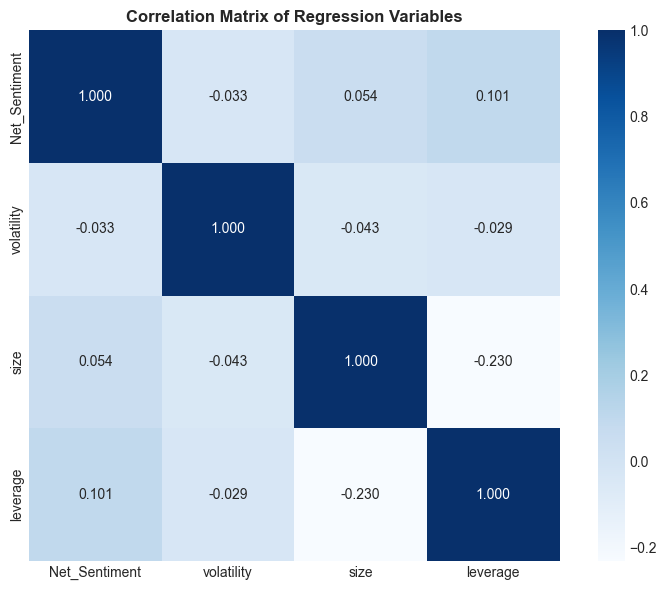

In [39]:
# Multicollinearity check among key regression variables
print("Multicollinearity check:")
print()

# Select relevant columns
corr_vars = ['Net_Sentiment', 'volatility', 'size', 'leverage']
corr_matrix = regression_df[corr_vars].corr()

print("Correlation matrix:")
print()
print(corr_matrix.round(3))

# Check for high correlations
high_corr = corr_matrix.abs().where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
).stack()

if not high_corr[high_corr > 0.7].empty:
    print("\nHigh correlations detected (>0.7):")
    for (var1, var2), value in high_corr[high_corr > 0.7].items():
        print(f"  {var1} - {var2}: {value:.3f}")
else:
    print("\nNo problematic multicollinearity detected (all correlations < 0.7)")

# Create simple heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, 
           annot=True,           # Show correlation values
           cmap='Blues',         # Color map 
           square=True,          # Make cells square
           fmt='.3f')            # Format numbers to 3 decimal places

plt.title('Correlation Matrix of Regression Variables', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Variance Inflation Factor (VIF) Analysis
print("Variance Inflation Factor (VIF) Analysis")
print()
print("VIF > 5 = potential concern, VIF > 10 = serious concern")
print()

# Select the variables used in the regression
variables_to_check = ['Net_Sentiment', 'volatility', 'size', 'leverage']

# Get clean data (no missing values) for VIF calculation
clean_data = regression_df_final[variables_to_check].dropna()

# Add constant term (intercept) that statsmodels needs
clean_data_with_constant = sm.add_constant(clean_data)

# Calculate VIF for each variable (skip the constant column)
print("VIF Results:")
print()
for i in range(len(variables_to_check)):  # Loop through each variable
    # Calculate VIF for variable at position i+1 (skip constant at position 0)
    vif_value = variance_inflation_factor(clean_data_with_constant.values, i + 1)
    
    # Get the variable name
    variable_name = variables_to_check[i]
    
    # Determine if VIF indicates a problem
    if vif_value > 10:
        concern_level = "(SERIOUS CONCERN - high multicollinearity)"
    elif vif_value > 5:
        concern_level = "(MODERATE CONCERN - some multicollinearity)"
    else:
        concern_level = "(no concern)"
    
    # Print the result
    print(f"  {variable_name}: {vif_value:.2f} {concern_level}")

print()

# Check if any VIF is too high
high_vif_count = 0
for i in range(len(variables_to_check)):
    vif_value = variance_inflation_factor(clean_data_with_constant.values, i + 1)
    if vif_value > 5:
        high_vif_count += 1

# Give final assessment
if high_vif_count == 0:
    print("No multicollinearity problems detected (all VIF values ≤ 5)")
else:
    print(f"{high_vif_count} variable(s) show potential multicollinearity")
   

Variance Inflation Factor (VIF) Analysis

VIF > 5 = potential concern, VIF > 10 = serious concern

VIF Results:

  Net_Sentiment: 1.01 (no concern)
  volatility: 1.00 (no concern)
  size: 1.07 (no concern)
  leverage: 1.07 (no concern)

No multicollinearity problems detected (all VIF values ≤ 5)


## Summary

This analysis shows that **earnings call sentiment is a significant predictor of short-term stock returns**. Using the Loughran-McDonald dictionary on 3,798 earnings calls from 60 companies:

- **Key Result:** A 1 percentage point increase in net sentiment leads to a 0.179 percentage point rise in cumulative abnormal returns (CAR).
- **Robustness:** Results hold after controlling for volatility, size, and leverage, with no multicollinearity concerns.

